In [1]:
import numpy as np
from scipy import optimize
from decimal import Decimal, getcontext
import matplotlib.pyplot as plt

## Payoff Matrix

At each state, we solve a simultaneous-move game:

- Pitcher (row player, minimizer) chooses Ball or Strike
- Batter (column player, maximizer) chooses Wait or Swing


In [2]:
def solve_nash_2x2(a, b, c, d):
    """
    Payoff matrix (batter perspective):
                Wait  Swing
       Ball      a     b
       Strike    c     d
    Returns: (prob_ball, prob_wait)
    """
    # edge cases
    # Pitcher dominance (minimizer prefers lower values)
    if a <= c and b <= d:  # Ball dominates Strike
        return (1.0, 1.0 if a >= b else 0.0)
    if c <= a and d <= b:  # Strike dominates Ball
        return (0.0, 1.0 if c >= d else 0.0)

    # Batter dominance (maximizer prefers higher values)
    if a >= b and c >= d:  # Wait dominates Swing
        return (1.0 if a <= c else 0.0, 1.0)
    if b >= a and d >= c:  # Swing dominates Wait
        return (1.0 if b <= d else 0.0, 0.0)

    # Mixed strategy
    # Pitcher mixes to make batter indifferent: prob_ball = (d-c)/(a-b-c+d)
    # Batter mixes to make pitcher indifferent: prob_wait = (d-b)/(a-b-c+d)
    denom = a - b - c + d
    if abs(denom) < 1e-12:
        return (0.5, 0.5)

    prob_ball = np.clip((d - c) / denom, 0, 1)
    prob_wait = np.clip((d - b) / denom, 0, 1)

    return (prob_ball, prob_wait)


# Test with simple examples
print("Test 1: Pure strategy equilibrium (Strike dominates)")
print("  Input: a=1, b=2, c=0, d=1")
print(f"  Nash: {solve_nash_2x2(1, 2, 0, 1)}")
print("  Expected: (0.0, 0.0) - Strike/Swing\n")

print("Test 2: Mixed strategy equilibrium")
print("  Input: a=3, b=0, c=0, d=1")
prob_ball, prob_wait = solve_nash_2x2(3, 0, 0, 1)
print(f"  Nash: ({prob_ball:.4f}, {prob_wait:.4f})")
print("  Expected: (0.25, 0.25)")

Test 1: Pure strategy equilibrium (Strike dominates)
  Input: a=1, b=2, c=0, d=1
  Nash: (0.0, 0.0)
  Expected: (0.0, 0.0) - Strike/Swing

Test 2: Mixed strategy equilibrium
  Input: a=3, b=0, c=0, d=1
  Nash: (0.2500, 0.2500)
  Expected: (0.25, 0.25)


## Backward Induction: Computing Value Function

Compute V(b,s) = expected value (from batter's perspective) for each state under optimal play.


In [3]:
def compute_value_and_strategies(p):
    # here V is the payout matrix where each cell V(b, s) corresponds
    # to the expected value at state (b, s) under GTO
    V = {}
    strategies = {}

    # Terminal states
    for s in range(3):
        V[(4, s)] = 1.0  # Walk
    for b in range(5):
        V[(b, 3)] = 0.0  # Strikeout

    # Backward induction
    for b in range(3, -1, -1):
        for s in range(2, -1, -1):
            a = V.get((b + 1, s), 0)  # Ball, Wait
            b_val = V.get((b, s + 1), 0)  # Ball, Swing
            c = V.get((b, s + 1), 0)  # Strike, Wait
            d = p * 4 + (1 - p) * V.get((b, s + 1), 0)  # Strike, Swing

            prob_ball, prob_wait = solve_nash_2x2(a, b_val, c, d)
            strategies[(b, s)] = (prob_ball, prob_wait)

            V[(b, s)] = (
                prob_ball * prob_wait * a
                + prob_ball * (1 - prob_wait) * b_val
                + (1 - prob_ball) * prob_wait * c
                + (1 - prob_ball) * (1 - prob_wait) * d
            )

    return V, strategies


# Test with p=0.5
print("Testing with p=0.5:")
V_test, strat_test = compute_value_and_strategies(0.5)
print(f"V(0,0) = {V_test[(0, 0)]:.6f}")
print(f"V(3,2) = {V_test[(3, 2)]:.6f}")
print(
    f"\nStrategies at (0,0): prob_ball={strat_test[(0, 0)][0]:.6f}, prob_wait={strat_test[(0, 0)][1]:.6f}"
)
print(
    f"Strategies at (3,2): prob_ball={strat_test[(3, 2)][0]:.6f}, prob_wait={strat_test[(3, 2)][1]:.6f}"
)

# Sanity check: V should be between 0 and 4
print(f"\nSanity check: All V in [0,4]? {all(0 <= v <= 4 for v in V_test.values())}")

Testing with p=0.5:
V(0,0) = 0.919179
V(3,2) = 0.666667

Strategies at (0,0): prob_ball=0.856649, prob_wait=0.856649
Strategies at (3,2): prob_ball=0.666667, prob_wait=0.666667

Sanity check: All V in [0,4]? True


## Computing Q-Function: Probability of Reaching Full Count

Q(b,s) = probability of reaching state (3,2) starting from state (b,s).


In [4]:
def compute_q_function(p, strategies):
    Q = {}
    Q[(3, 2)] = 1.0

    # Terminal states
    for s in range(3):
        Q[(4, s)] = 0.0
    for b in range(5):
        Q[(b, 3)] = 0.0

    # Backward induction
    for b in range(3, -1, -1):
        for s in range(2, -1, -1):
            if (b, s) in Q:
                continue

            prob_ball, prob_wait = strategies[(b, s)]

            Q[(b, s)] = (
                prob_ball * prob_wait * Q.get((b + 1, s), 0)
                + prob_ball * (1 - prob_wait) * Q.get((b, s + 1), 0)
                + (1 - prob_ball) * prob_wait * Q.get((b, s + 1), 0)
                + (1 - prob_ball) * (1 - prob_wait) * (1 - p) * Q.get((b, s + 1), 0)
            )

    return Q


# Test with p=0.5
Q_test = compute_q_function(0.5, strat_test)
print("Testing with p=0.5:")
print(f"Q(0,0) = {Q_test[(0, 0)]:.6f}")
print(f"Q(3,2) = {Q_test[(3, 2)]:.6f}")
print(f"Q(2,1) = {Q_test[(2, 1)]:.6f}")

Testing with p=0.5:
Q(0,0) = 0.184180
Q(3,2) = 1.000000
Q(2,1) = 0.378725


## Optimization: Finding p\* that Maximizes q

Find the value of p ∈ [0,1] that maximizes Q(0,0), the probability of reaching full count.


In [5]:
def objective(p):
    V, strategies = compute_value_and_strategies(p)
    Q = compute_q_function(p, strategies)
    # negate so we can utilize scipy.minimize
    return -Q[(0, 0)]


print("Optimizing to find p* that maximizes q = Q(0,0)...")
result = optimize.minimize_scalar(
    objective, bounds=(0, 1), method="bounded", options={"xatol": 1e-12}
)

p_opt = result.x
q_opt = -result.fun

print(f"\n{'=' * 70}")
print("OPTIMIZATION RESULT")
print(f"{'=' * 70}")
print(f"Optimal p* = {p_opt:.12f}")
print(f"Maximum q  = {q_opt:.12f}")
print(f"{'=' * 70}")

Optimizing to find p* that maximizes q = Q(0,0)...

OPTIMIZATION RESULT
Optimal p* = 0.226973232458
Maximum q  = 0.295967993374


## Visualization: q(p) vs p

Plot the objective function to verify we found the global maximum.


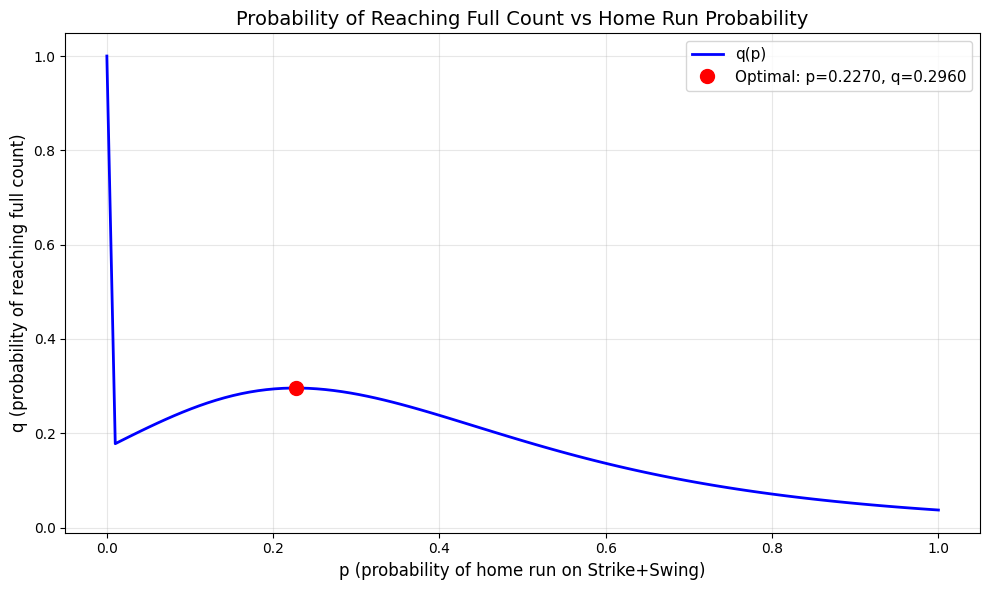

0.2269732324584755


In [6]:
# Compute q for range of p values
p_values = np.linspace(0, 1, 100)
q_values = []

for p in p_values:
    V, strategies = compute_value_and_strategies(p)
    Q = compute_q_function(p, strategies)
    q_values.append(Q[(0, 0)])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(p_values, q_values, "b-", linewidth=2, label="q(p)")
plt.plot(
    p_opt, q_opt, "ro", markersize=10, label=f"Optimal: p={p_opt:.4f}, q={q_opt:.4f}"
)
plt.xlabel("p (probability of home run on Strike+Swing)", fontsize=12)
plt.ylabel("q (probability of reaching full count)", fontsize=12)
plt.title("Probability of Reaching Full Count vs Home Run Probability", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(p_opt)

Examine the Nash equilibrium strategies at the optimal p.


In [7]:
V_opt, strat_opt = compute_value_and_strategies(p_opt)

print(f"Nash Equilibrium Strategies at p* = {p_opt:.6f}\n")
print("State (b,s)  |  prob_ball  |  prob_wait  |  V(b,s)")
print("-" * 55)

for b in range(4):
    for s in range(3):
        prob_b, prob_w = strat_opt[(b, s)]
        v = V_opt[(b, s)]
        print(f"  ({b},{s})      |   {prob_b:.4f}    |   {prob_w:.4f}    |  {v:.4f}")

Nash Equilibrium Strategies at p* = 0.226973

State (b,s)  |  prob_ball  |  prob_wait  |  V(b,s)
-------------------------------------------------------
  (0,0)      |   0.7129    |   0.7129    |  0.6484
  (0,1)      |   0.7346    |   0.7346    |  0.4148
  (0,2)      |   0.7962    |   0.7962    |  0.1850
  (1,0)      |   0.6921    |   0.6921    |  0.7426
  (1,1)      |   0.6895    |   0.6895    |  0.4978
  (1,2)      |   0.7441    |   0.7441    |  0.2323
  (2,0)      |   0.6952    |   0.6952    |  0.8514
  (2,1)      |   0.6354    |   0.6354    |  0.6174
  (2,2)      |   0.6561    |   0.6561    |  0.3122
  (3,0)      |   0.7782    |   0.7782    |  0.9540
  (3,1)      |   0.6041    |   0.6041    |  0.7925
  (3,2)      |   0.4759    |   0.4759    |  0.4759
